Calibration
===========

Since we have our energy calibration stored within `run289.h5`, we can extract that energy calibration and apply it
to every other run from our third experimental campaign. From there, we can extract the counts within each alpha peak, check that the peak energy matches what we expect from our initial parameters, and perform the first analysis on the resonant cross section determination.

The final runs, after doing all our beam checks, are the following numbers: 228, 234, 241, 248, 255, 260, 264, 270, 277, 282, and 288.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pyne
pyne.__version__

'0.2.10'

In [2]:
run_numbers = [228, 234, 241, 248, 255, 260, 264, 270, 277, 282, 288]

calibration = pyne.Data('evt', output_file='../data_processed/run289.h5')
calibration.load_data()
final_runs = [pyne.Data('evt', output_file='../data_processed/run{}.h5'.format(run))
              for run in run_numbers]
for run in final_runs:
    run.load_data()

reading from ../data_processed/run289.h5...
reading from ../data_processed/run228.h5...
reading from ../data_processed/run234.h5...
reading from ../data_processed/run241.h5...
reading from ../data_processed/run248.h5...
reading from ../data_processed/run255.h5...
reading from ../data_processed/run260.h5...
reading from ../data_processed/run264.h5...
reading from ../data_processed/run270.h5...
reading from ../data_processed/run277.h5...
reading from ../data_processed/run282.h5...
reading from ../data_processed/run288.h5...


[  -85.61467588   -83.96130235   -82.30792881 ...,  6681.6432165
  6683.29659004  6684.94996358]
  using calibrated spectra


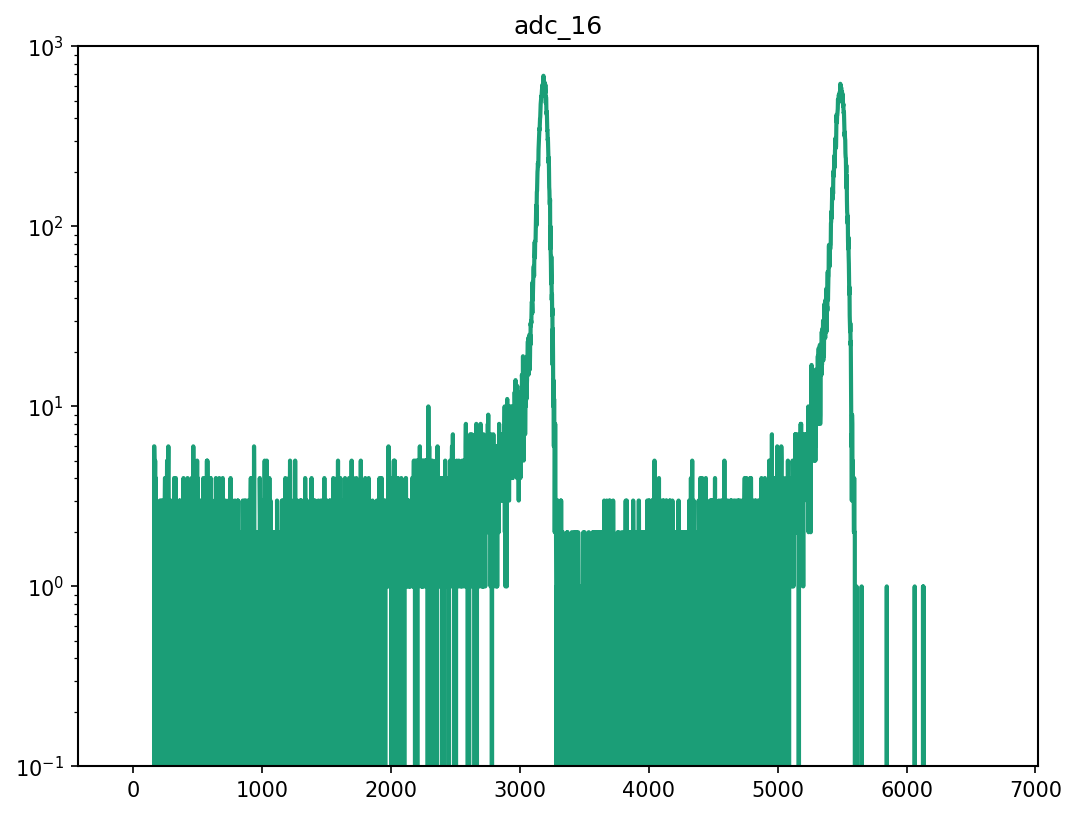

In [3]:
print(calibration.adc[16].energies)
calibration.adc[16].display(log=True, calibrated=True)
plt.show()

In [5]:
energies = [cal_adc.energies for cal_adc in calibration.adc[16:]]

for data in final_runs:
    for energy, adc in zip(energies, data.adc[16:]):
        adc.set_calibration(energy)
    data.save_data()

writing to ../data_processed/run228.h5...
writing to ../data_processed/run234.h5...
writing to ../data_processed/run241.h5...
writing to ../data_processed/run248.h5...
writing to ../data_processed/run255.h5...
writing to ../data_processed/run260.h5...
writing to ../data_processed/run264.h5...
writing to ../data_processed/run270.h5...
writing to ../data_processed/run277.h5...
writing to ../data_processed/run282.h5...
writing to ../data_processed/run288.h5...


In [4]:
# apply calibration to all runs: 173 -- 288

energies = [cal_adc.energies for cal_adc in calibration.adc[16:]]

runs = range(173, 289, 1)
for run_number in runs:
    data = pyne.Data('evt', output_file='../data_processed/run{}.h5'.format(run_number))
    data.load_data()
    for energy, adc in zip(energies, data.adc[16:]):
        adc.set_calibration(energy)
    data.save_data()

reading from ../data_processed/run173.h5...
writing to ../data_processed/run173.h5...
reading from ../data_processed/run174.h5...
writing to ../data_processed/run174.h5...
reading from ../data_processed/run175.h5...
writing to ../data_processed/run175.h5...
reading from ../data_processed/run176.h5...
writing to ../data_processed/run176.h5...
reading from ../data_processed/run177.h5...
writing to ../data_processed/run177.h5...
reading from ../data_processed/run178.h5...
writing to ../data_processed/run178.h5...
reading from ../data_processed/run179.h5...
writing to ../data_processed/run179.h5...
reading from ../data_processed/run180.h5...
writing to ../data_processed/run180.h5...
reading from ../data_processed/run181.h5...
writing to ../data_processed/run181.h5...
reading from ../data_processed/run182.h5...
writing to ../data_processed/run182.h5...
reading from ../data_processed/run183.h5...
writing to ../data_processed/run183.h5...
reading from ../data_processed/run184.h5...
writing to

Sum Peak
--------

As a quick check, we can take the sum of all of the alpha peaks to give a quick estimate of our yield, without taking into account any of the systematic uncertainties. We can't simply add the detectors together, since the individual energy calibrations don't line up properly.

We could potentially create a new energy range and rebin everything into that range, but that's probably more work than it's worth, so just a by strip version will do.

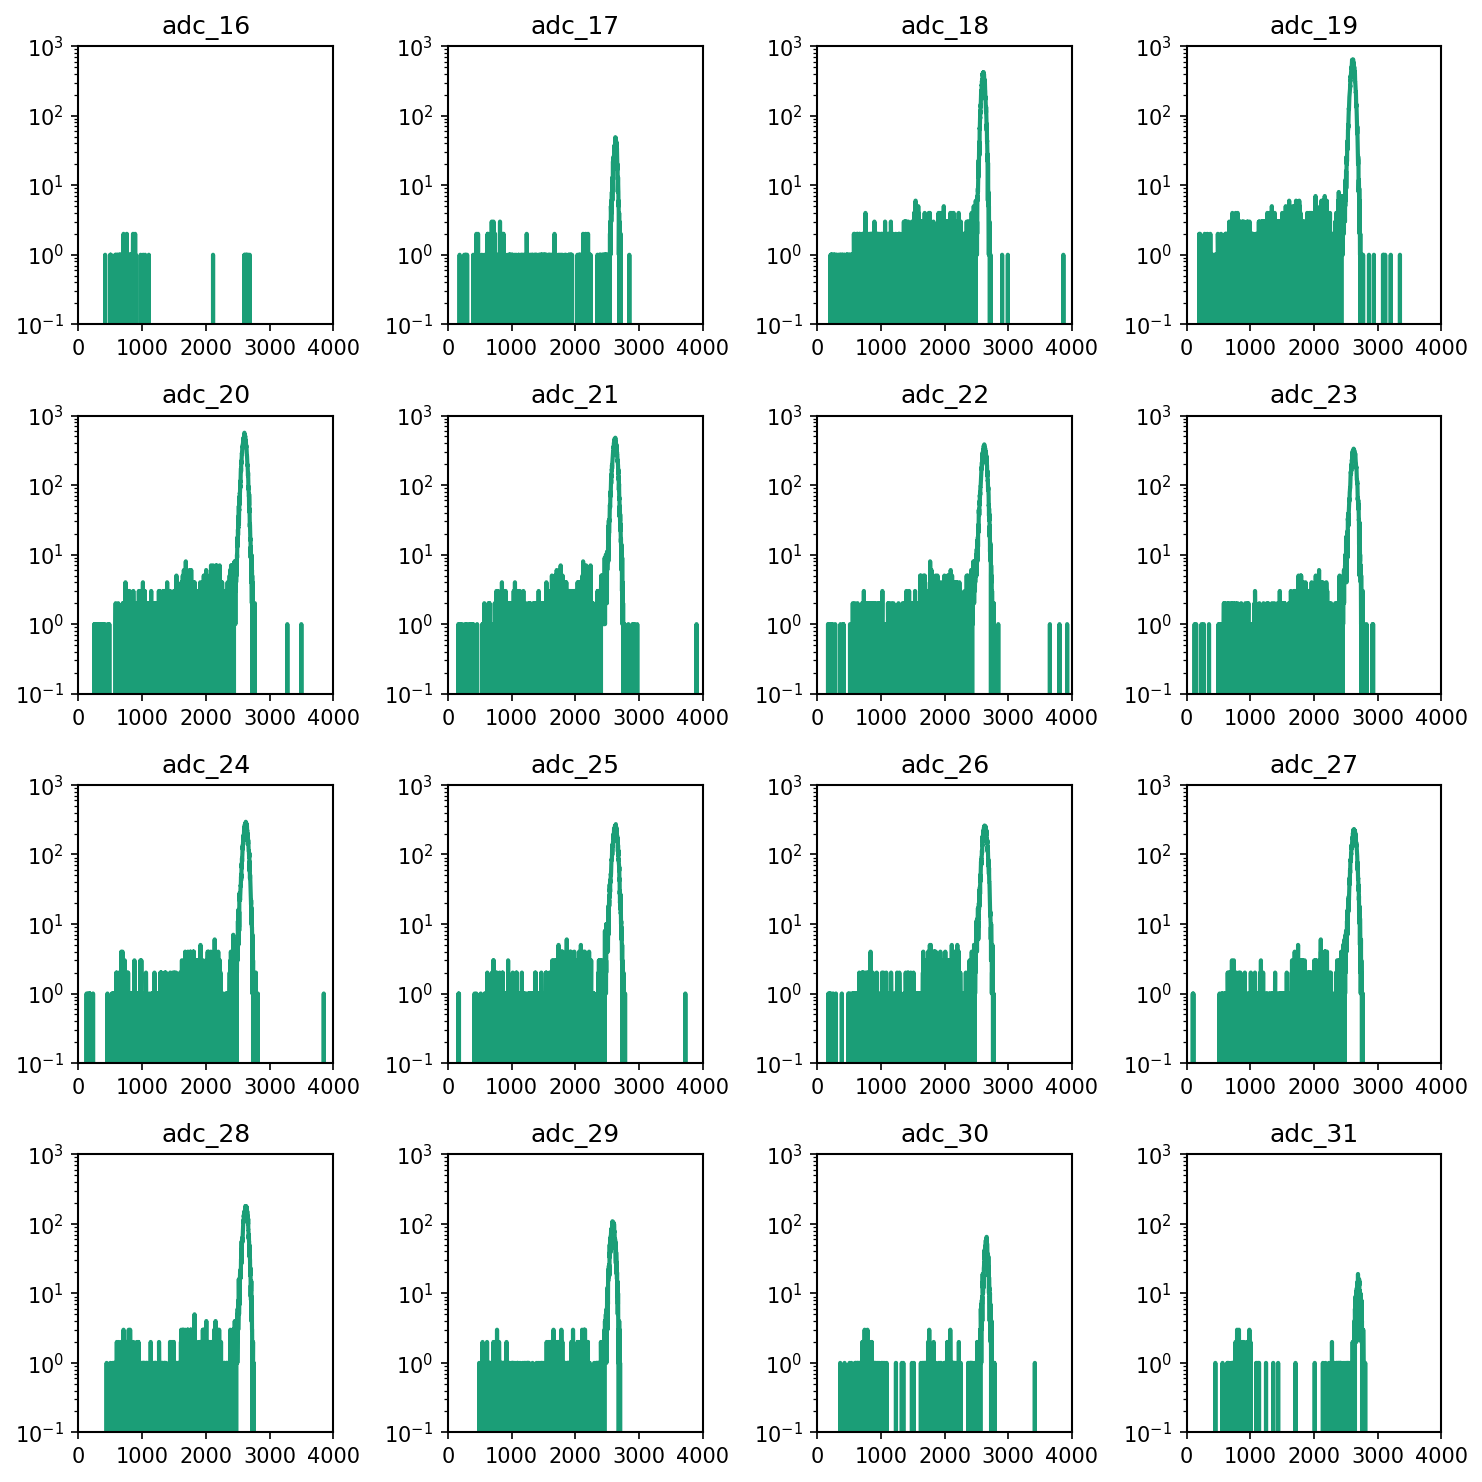

  using calibrated spectra


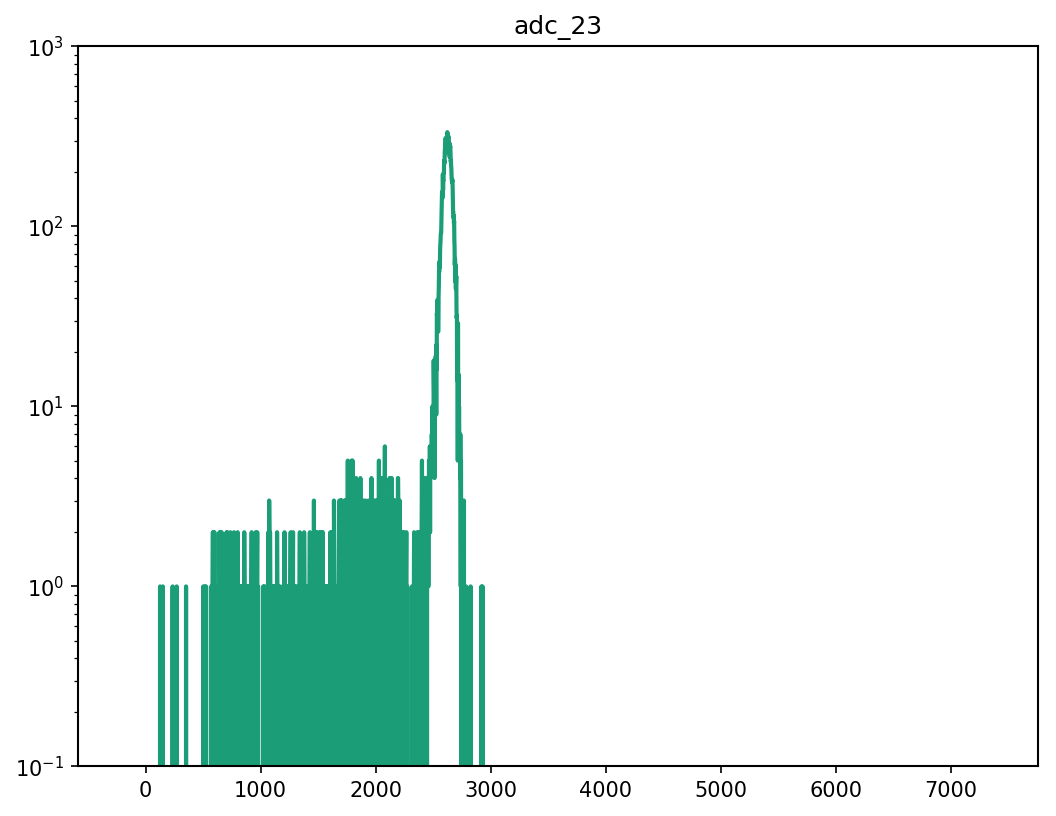

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axis = axes.ravel()

for ax, adc in zip(axis, final_runs[0].adc[16:]):
    ax.semilogy(adc.energies, adc.counts, nonposy='clip')
    ax.set_ylim((0.1, 1000))
    ax.set_xlim((0, 4000))
    ax.set_title(adc.name)
fig.tight_layout()
plt.show()

final_runs[0].adc[23].display(log=True, calibrated=True)
plt.show()

In [9]:
run_numbers

[228, 234, 241, 248, 255, 260, 264, 270, 277, 282, 288]

[  708.92280538  2815.21220514    39.17856817]
  using calibrated spectra


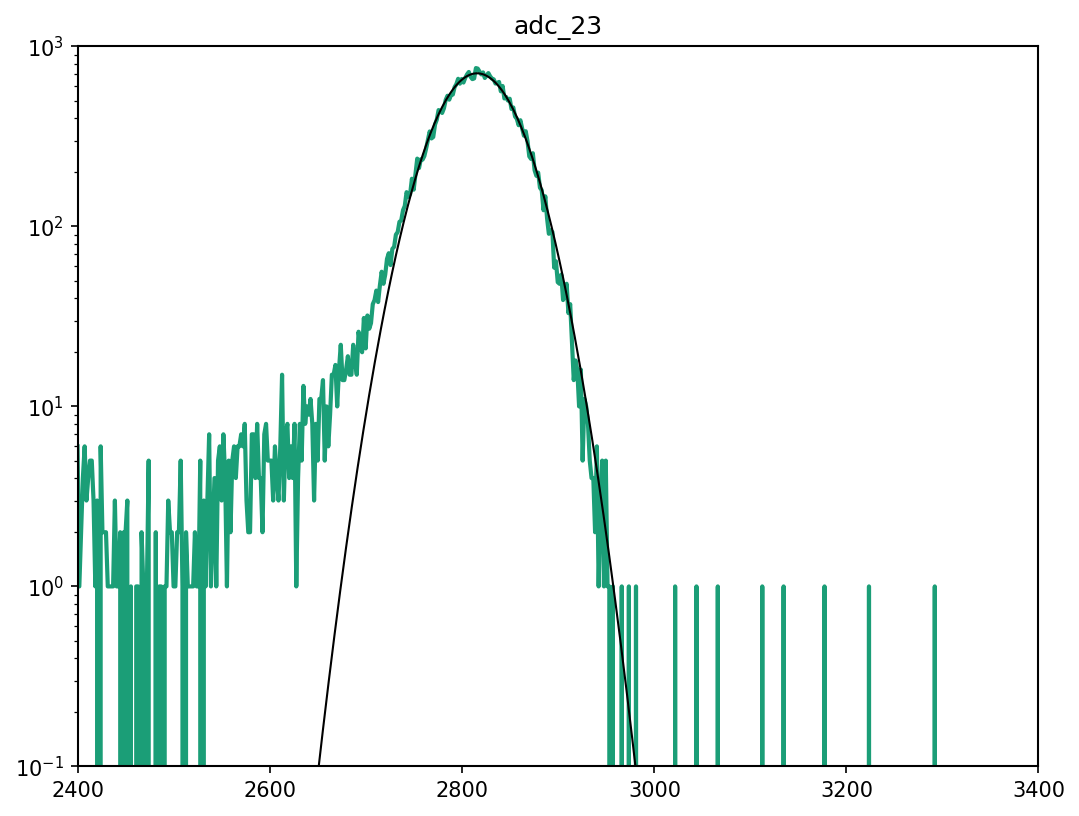

In [10]:
# use adc[23] as center strip

from scipy.optimize import curve_fit

def gaussian(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

det = final_runs[-4].adc[23]
p0 = [600, 2750, 50]
par, _ = curve_fit(gaussian, det.energies, det.counts, p0=p0)

print(par)
x = np.linspace(2000, 4000, 1000)
fig, ax = det.display(log=True, calibrated=True)
ax.semilogy(x, gaussian(x, *par), 'k-', lw=1, nonposy='clip')
ax.set_ylim((0.1, 1000))
ax.set_xlim((2400, 3400))
plt.show()

We'll get values from where our function crosses $y = 1$, and use that range to integrate our function. I am assuming that the peak locations will be at the same point in the energy spectrum, and in any case in those strips where we don't see a peak, we have to rely on some window to count the number of events.

In [11]:
par[1]

2815.212205143152

In [12]:
from scipy.optimize import newton

def gaussian_offset(x):
    return gaussian(x, *par) - 1

left_side = newton(gaussian_offset, par[1] - 100)
right_side = newton(gaussian_offset, par[1] + 100)

roots = np.array([left_side - 10, right_side + 5])  # extra 5/10 keV
roots

array([ 2663.26087626,  2962.16353403])

In [13]:
roots2 = np.array([par[1] - 7 * par[2], par[1] + 9 * par[2]])
roots2

array([ 2540.96222793,  3167.8193187 ])

  using calibrated spectra


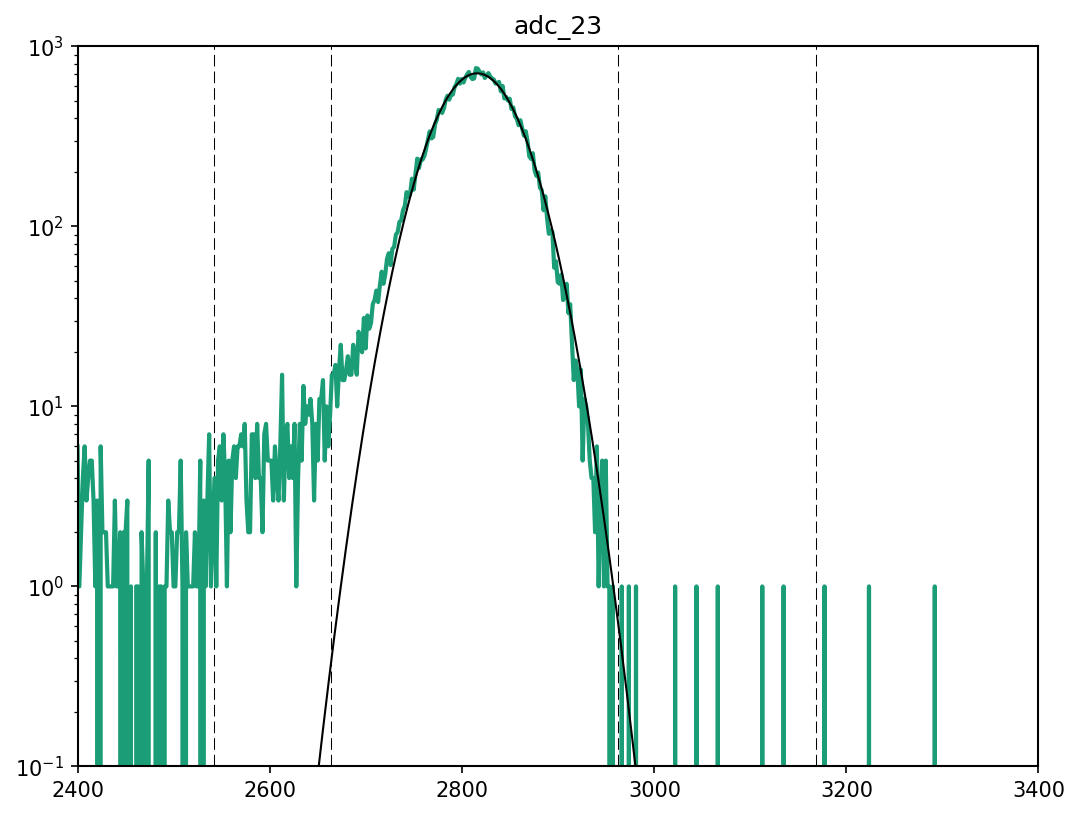

In [14]:
x = np.linspace(2000, 4000, 1000)
fig, ax = det.display(log=True, calibrated=True)
ax.semilogy(x, gaussian(x, *par), 'k-', lw=1, nonposy='clip')
ax.set_ylim((0.1, 1000))
ax.set_xlim((2400, 3400))
ax.vlines(roots, 0.1, 1000, 'k', linestyles='dashed', lw=0.5)
ax.vlines(roots2, 0.1, 1000, 'k', linestyles='dashed', lw=0.5)
plt.show()

In [15]:
bin_indices = np.searchsorted(det.energies, roots2)
bin_indices

array([1482, 1820])

In [16]:
total = det.counts[bin_indices[0]:bin_indices[1] + 1].sum()
total

38468

Looking at our rough count values on the Google Drive, we recorded 39051 counts for this strip. I know that our window was larger than what we're using, and looking at the above plot, we may also be missing some of the Lorentz low energy tailing for our counts, but I think we're OK.

In [17]:
std = np.sqrt(total)
print('{:.0f} +/- {:.0f} ({:.0f}, {:.0f})'.format(
        total, std, total - std, total + std))

38468 +/- 196 (38272, 38664)


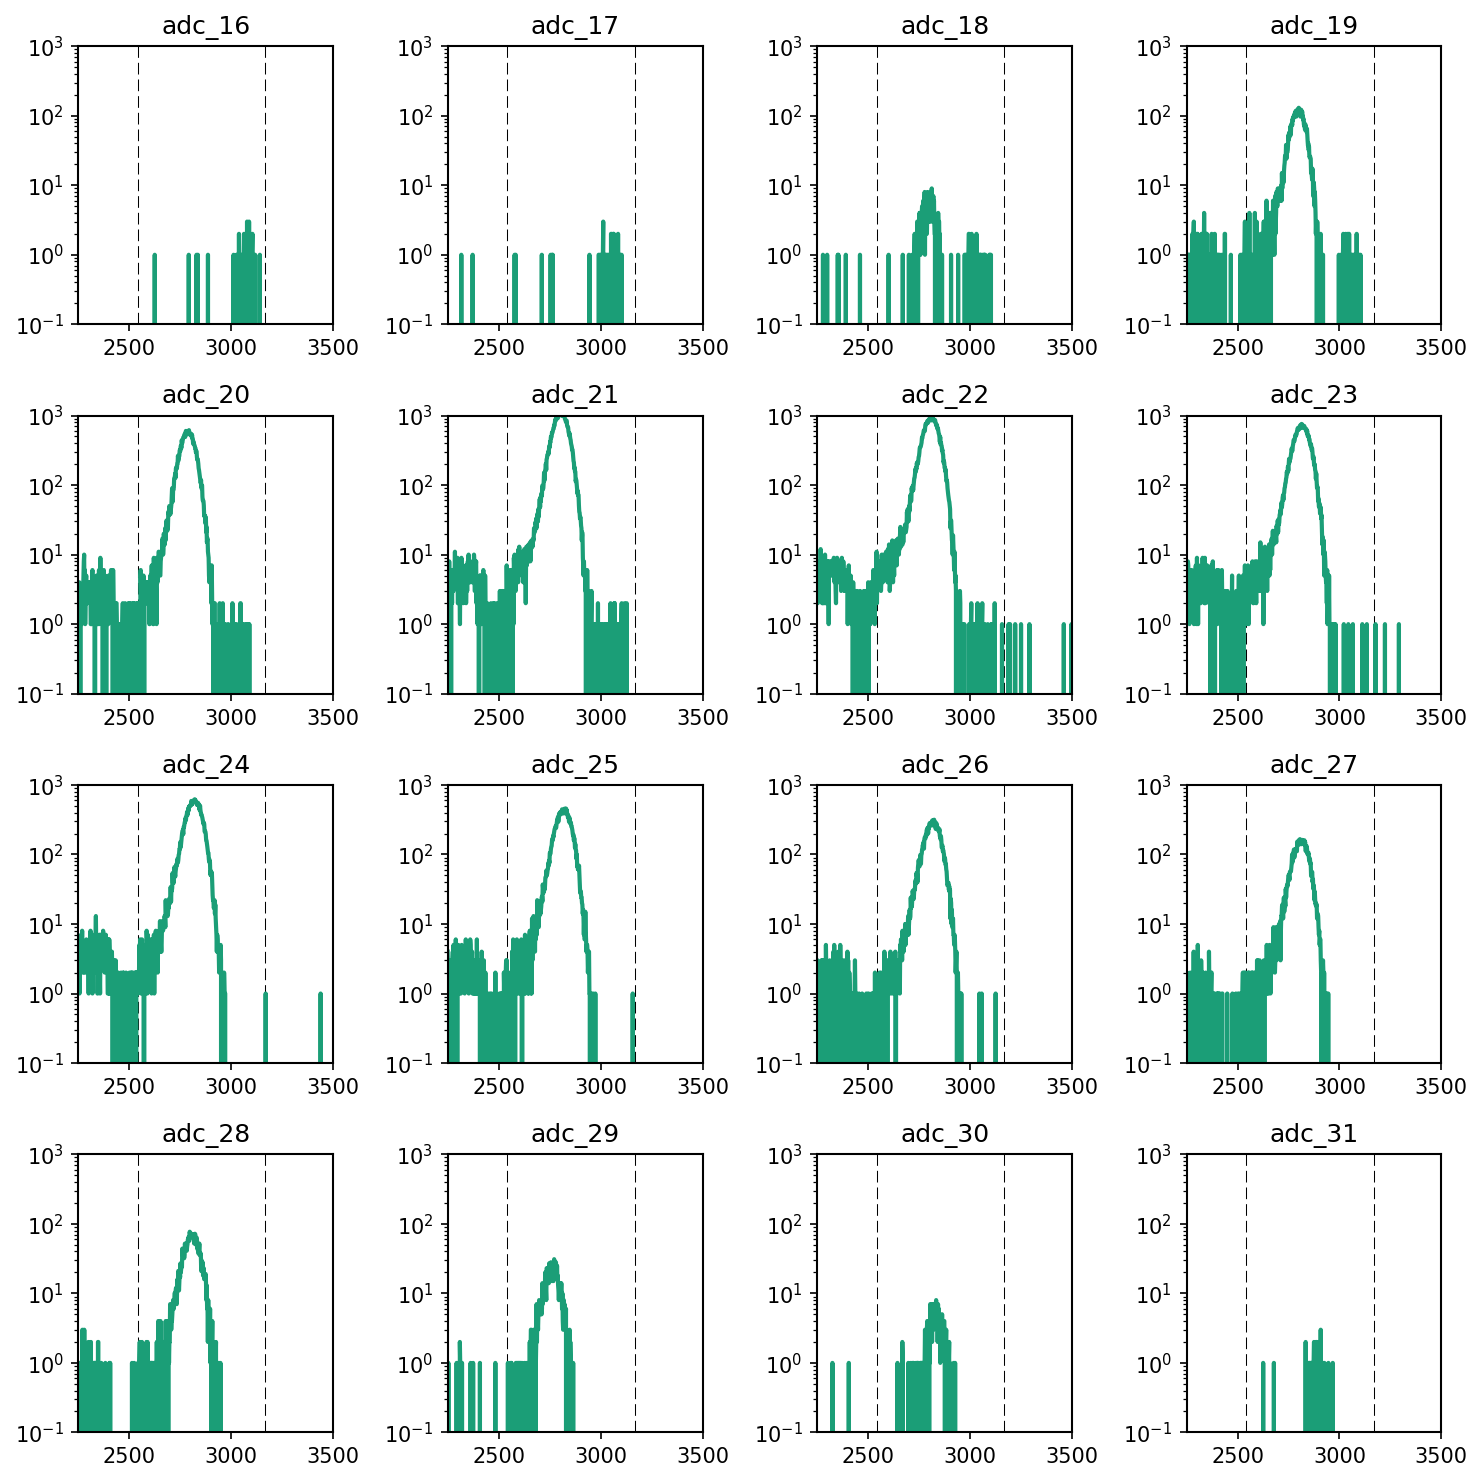

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axis = axes.ravel()

for ax, adc in zip(axis, final_runs[-4].adc[16:]):
    ax.semilogy(adc.energies, adc.counts, nonposy='clip')
    ax.vlines(roots2, 0.1, 1000, 'k', linestyles='dashed', lw=0.5)
    ax.set_ylim((0.1, 1000))
    ax.set_xlim((2250, 3500))
    ax.set_title(adc.name)
fig.tight_layout()
plt.show()

In [40]:
total = 0
counts = [0]

for d in final_runs[-4].adc[16:]:
    bin_indices = np.searchsorted(d.energies, roots2)
    t = d.counts[bin_indices[0]:bin_indices[1] + 1].sum()
    total += t
    counts.append(t)
    print('{}: {:.0f} +/- {:.0f}'.format(d.name, t, np.sqrt(t)))

counts.append(0)
print('total: {:.0f} +/- {:.0f}'.format(total, np.sqrt(total)))

adc_16: 46 +/- 7
adc_17: 42 +/- 6
adc_18: 289 +/- 17
adc_19: 6206 +/- 79
adc_20: 31175 +/- 177
adc_21: 57346 +/- 239
adc_22: 50091 +/- 224
adc_23: 38468 +/- 196
adc_24: 31084 +/- 176
adc_25: 23106 +/- 152
adc_26: 15363 +/- 124
adc_27: 8198 +/- 91
adc_28: 3571 +/- 60
adc_29: 1169 +/- 34
adc_30: 235 +/- 15
adc_31: 34 +/- 6
total: 266423 +/- 516


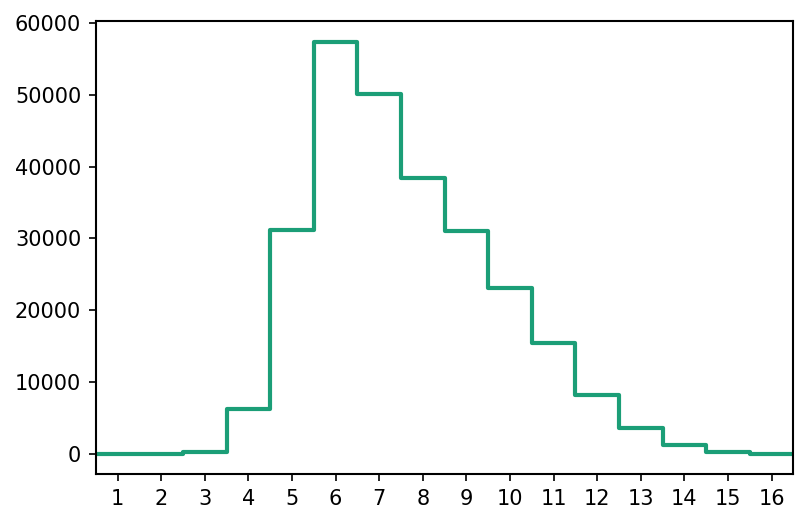

In [33]:
plt.plot(np.arange(18), counts, linestyle='steps-mid')
plt.xticks(np.arange(16) + 1)
plt.xlim((0.5, 16.5))
plt.show()

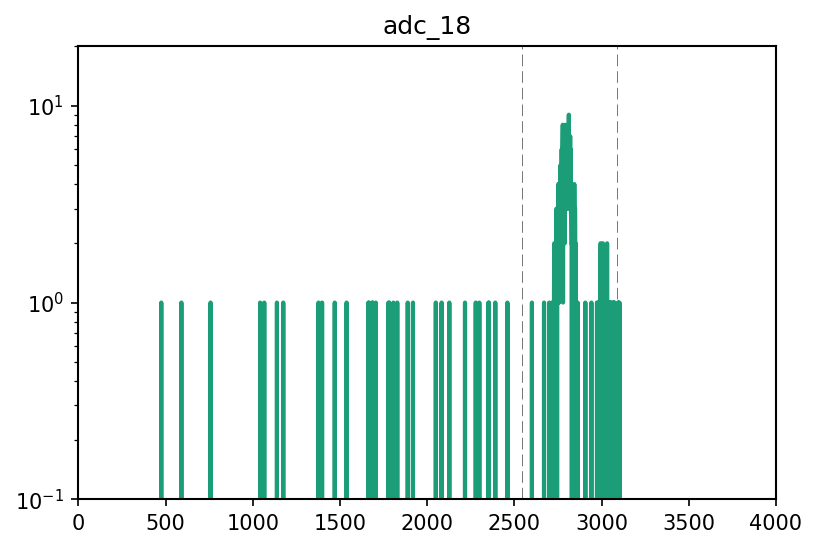

In [25]:
adc = final_runs[-4].adc[18]

plt.semilogy(adc.energies, adc.counts, nonposy='clip')
plt.vlines(roots2, 0.1, 1000, 'k', linestyles='dashed', lw=0.25)
plt.ylim((0.1, 20))
plt.xlim((0, 4000))
plt.title(adc.name)

plt.show()

In [26]:
bin_indices = np.searchsorted(adc.energies, roots2)

offset = 0
subcounts = adc.counts[bin_indices[0] + offset:bin_indices[1] + offset]
subcounts, subcounts.sum()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 0, 2, 3, 1, 1, 4, 1, 4, 1, 3,
        3, 4, 4, 5, 4, 2, 2, 6, 3, 2, 6, 8, 1, 6, 3, 4, 3, 6, 2, 4, 8, 4, 5,
        7, 3, 3, 4, 4, 3, 8, 4, 7, 5, 9, 3, 4, 6, 5, 7, 4, 6, 3, 2, 2, 0, 3,
        0, 2, 1, 1, 2, 1, 0, 4, 2, 3, 3, 1, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,

  using calibrated spectra


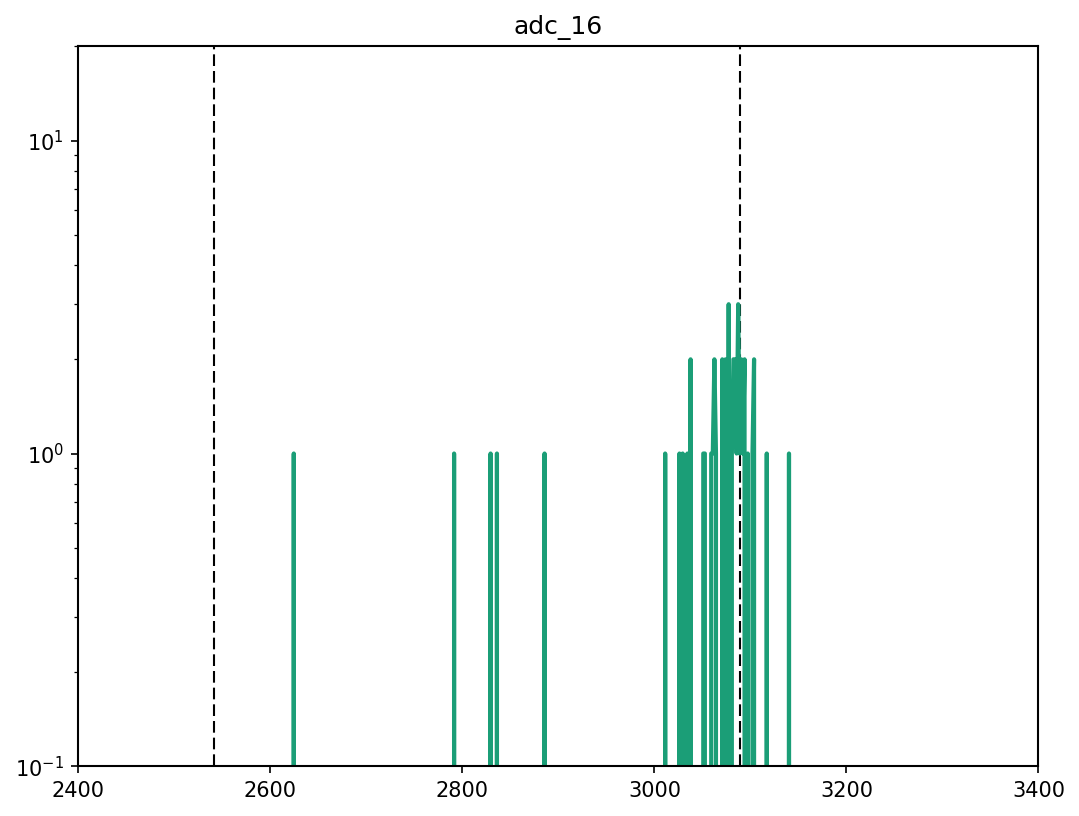

In [27]:
det = final_runs[-4].adc[16]

fig, ax = det.display(log=True, calibrated=True)
ax.vlines(roots2, 0.1, 1000, 'k', linestyles='dashed', lw=1)
ax.set_ylim((0.1, 20))
ax.set_xlim((2400, 3400))

plt.show()

Things to remember:
-------------------

1. After finding roots, make sure that you refind `bin_indices` for each calibrated energy spectrum. This is the same reason why you couldn't just sum the values, but you forgot to do that the first time through for a while.
1. Plotting log with `y_min = 1` hides all of those bins that have 1 count in them.
1. You can loop through a single detector array and do the analysis that you'll need, and get statistical uncertainties! You still need to figure out systematic uncertainties.
1. This is `sap`, so actually put it into `sap`. At the very least, helpers (like full detector plot display) should be included so that you don't need to rewrite them every time.